# Imports and Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from rl_env.pendulum_env import CustomInvertedPendulum
from agent.utils import SimplePolicyNet
from agent.evolution_strategy import EvolutionStrategy

# Set random seed for reproducibility
np.random.seed(42)

# Initialize Environment and Policy

In [13]:
env = CustomInvertedPendulum()

# Define the policy network
policy = SimplePolicyNet(input_dim=3, hidden_dim=8, output_dim=1)

# Create an ES agent with small population for demonstration
es = EvolutionStrategy(
    policy=policy,
    env=env,
    n_perturb=10,   # small population for manual inspection
    sigma=0.1,
    alpha=0.02,
    episodes=5
)


# Evaluate Initial Policy

In [14]:
def rollout(policy, env, steps=200, render=False):
    state = env.reset()
    total_reward = 0.0
    for _ in range(steps):
        action = policy.get_action(state)
        state, reward, done = env.step(action)
        total_reward += reward
    return total_reward

# Run one evaluation of the initial policy
initial_score = rollout(policy, env)
print(f"Initial policy score: {initial_score:.2f}")


Initial policy score: -1416.16


## Note: NumbaPerformanceWarning

This warning appears because `np.dot()` is initially called on arrays that aren't guaranteed to be **C-contiguous** in memory (e.g., `features` and `weights1`). This is common during the **first forward pass**, when arrays are freshly created or reshaped.

After one iteration of training (or even one call to `set_flat_params()`), the parameters are explicitly copied and reshaped using `np.ascontiguousarray(...)`, ensuring memory layout is optimal.

As a result, the warning typically disappears after the first training step because all future operations use contiguous memory buffers, making `np.dot()` fast and JIT-optimized.


# Apply one ES Step and Visulaize Pertubations

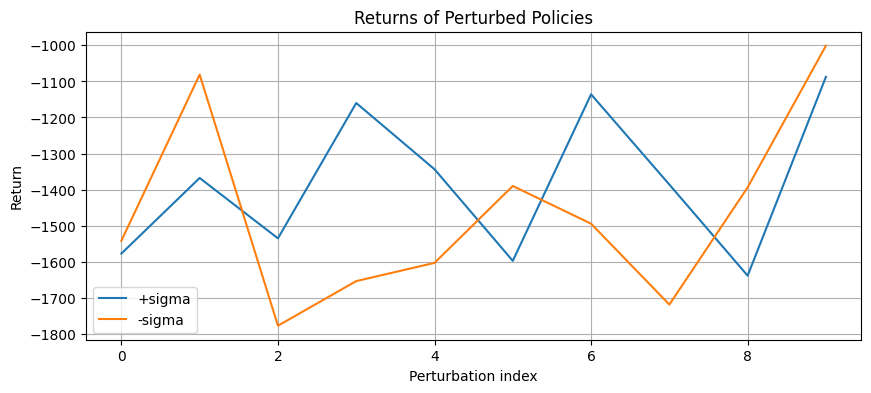

In [15]:
# Get baseline parameters
base_params = policy.get_flat_params()
dim = base_params.shape[0]

# Sample noise for perturbations
np.random.seed(0)  # for consistent results
noises = np.random.randn(es.n_perturb, dim)

returns = []

# Evaluate each positive and negative perturbation
for i in range(es.n_perturb):
    noise = noises[i]
    
    policy.set_flat_params(base_params + es.sigma * noise)
    pos_score = rollout(policy, env)
    
    policy.set_flat_params(base_params - es.sigma * noise)
    neg_score = rollout(policy, env)
    
    returns.append((pos_score, neg_score))

# Reset to original parameters
policy.set_flat_params(base_params)

# Plot return distribution
pos, neg = zip(*returns)
plt.figure(figsize=(10, 4))
plt.plot(pos, label="+sigma")
plt.plot(neg, label="-sigma")
plt.title("Returns of Perturbed Policies")
plt.xlabel("Perturbation index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


# Apply Update and Show Improvement

In [16]:
# Compute rewards difference and normalize
scores = np.array([p - n for p, n in returns])
scores_mean = np.mean(scores)
scores_std = np.std(scores)
normalized_scores = (scores - scores_mean) / (scores_std + 1e-8)

# Weighted sum of perturbations
gradient_estimate = np.zeros(dim)
for i in range(es.n_perturb):
    gradient_estimate += normalized_scores[i] * noises[i]
gradient_estimate /= es.n_perturb

# Apply gradient step
updated_params = base_params + es.alpha * gradient_estimate
policy.set_flat_params(updated_params)

# Evaluate new policy
updated_score = rollout(policy, env)

print(f"Original score: {initial_score:.2f}")
print(f"Updated score: {updated_score:.2f}")


Original score: -1416.16
Updated score: -973.92


# Run Short Training and Plot

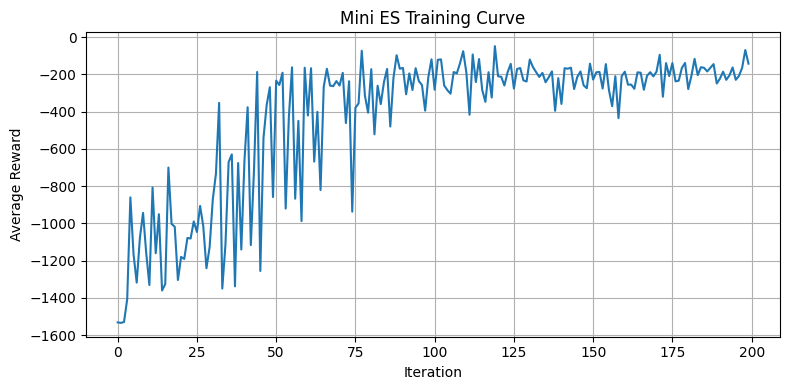

In [17]:
# Reset policy to original before training
policy.set_flat_params(base_params)

# Create a new ES instance with slightly larger n_perturb
es = EvolutionStrategy(
    policy=policy,
    env=env,
    n_perturb=50,
    sigma=0.3,
    alpha=0.001,
    episodes=5
)

# Run training
num_iterations = 200
reward_history = es.optimize(num_iterations)

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(reward_history)
plt.title("Mini ES Training Curve")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualize Rollout with Animation

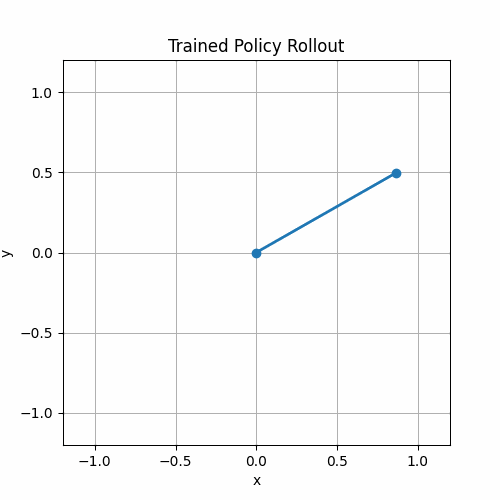

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import os

# Run rollout and record states
states = []
state = env.reset()
for _ in range(200):
    action = policy.get_action(state)
    state, _, _ = env.step(action)
    states.append(state)

states = np.array(states)
angles = states[:, 0]

# Compute pendulum tip coordinates
L = env.L
x = L * np.sin(angles)
y = L * np.cos(angles)

# Set up animation figure
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-L - 0.2, L + 0.2)
ax.set_ylim(-L - 0.2, L + 0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trained Policy Rollout")
ax.grid(True)
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(i):
    line.set_data([0, x[i]], [0, y[i]])
    return line,

ani = animation.FuncAnimation(
    fig, update, frames=len(x), init_func=init,
    interval=30, blit=True
)

# Ensure output directory exists
os.makedirs("../figs", exist_ok=True)

# Save and display the GIF
gif_path = "../figs/mini_es_trained_policy.gif"
ani.save(gif_path, writer="pillow", fps=30)
plt.close()

# Load GIF
Image(filename=gif_path)


# Analyis of Policy Behavior

After just a few iterations of evolution strategy training, the policy often learns to swing the pendulum **close to the upright position**, but fails to fully stabilize it. Instead, it may hover near the top and vibrate rapidly back and forth.

### Why does this happen?

- The policy has discovered that **being near the top** gives higher rewards than hanging at the bottom.
- However, it's still learning how to control **angular velocity and torque smoothly**, so it ends up **oscillating** or **overcorrecting** near the top.
- This creates a local maximum where the pendulum appears "almost balanced" but jittery.

In many cases, the agent prefers this unstable balance point because:
- It's **better than falling down** (higher reward)
- But **easier to reach** than perfect stabilization

---

### How to Address It

1. **Train Longer**  
   More ES iterations allow the agent to refine its parameters and reduce jitter.

2. **Adjust Reward Weights**  
   Increase the penalty on `angular_velocity` (`0.1 * dot_omega**2`) or `action**2` to encourage smoother movement:
   ```python
   reward = - (angle_error**2 + 0.2 * angular_velocity**2 + 0.01 * action**2)


# Improve Stability and Reduce Jittering

We implement the above fixes to determine if the policy improves.

In [33]:
env = CustomInvertedPendulum(torque_penalty=0.01)

policy = SimplePolicyNet(input_dim=3, hidden_dim=8, output_dim=1)

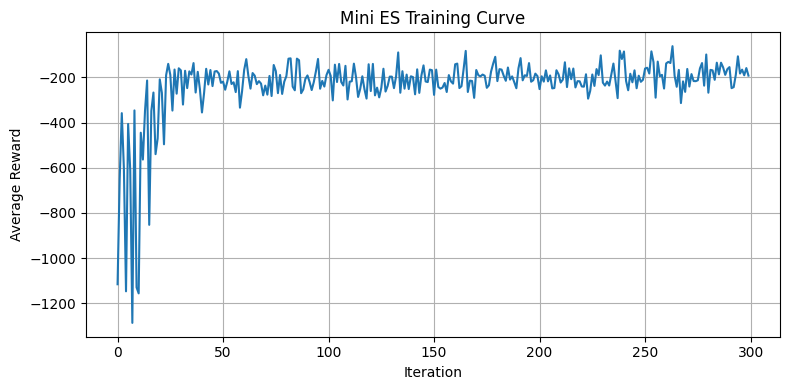

In [36]:
es = EvolutionStrategy(
    policy=policy,
    env=env,
    n_perturb=50,
    sigma=0.3,
    alpha=0.001,
    episodes=5
)

# Run training
num_iterations = 300
reward_history = es.optimize(num_iterations)

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(reward_history)
plt.title("Mini ES Training Curve")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


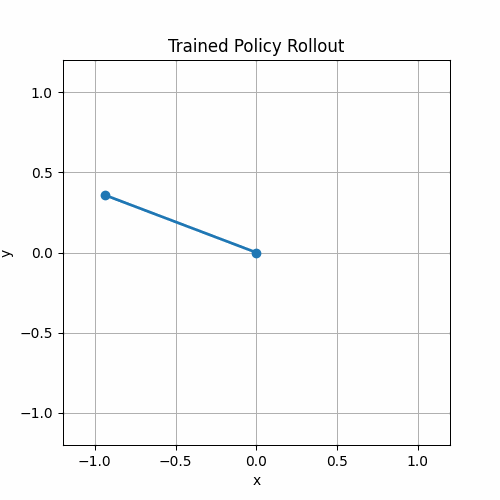

In [37]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import os

# Run rollout and record states
states = []
state = env.reset()
for _ in range(200):
    action = policy.get_action(state)
    state, _, _ = env.step(action)
    states.append(state)

states = np.array(states)
angles = states[:, 0]

# Compute pendulum tip coordinates
L = env.L
x = L * np.sin(angles)
y = L * np.cos(angles)

# Set up animation figure
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-L - 0.2, L + 0.2)
ax.set_ylim(-L - 0.2, L + 0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trained Policy Rollout")
ax.grid(True)
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    return line,

def update(i):
    line.set_data([0, x[i]], [0, y[i]])
    return line,

ani = animation.FuncAnimation(
    fig, update, frames=len(x), init_func=init,
    interval=30, blit=True
)

# Ensure output directory exists
os.makedirs("../figs", exist_ok=True)

# Save and display the GIF
gif_path = "../figs/improved_mini_es_trained_policy.gif"
ani.save(gif_path, writer="pillow", fps=30)
plt.close()

# Load GIF
Image(filename=gif_path)


## Analysis of Jittering Improvments

After modifying the reward function and introducing damping, the pendulum shows **promising signs of improved stability**. The jittering behavior near the upright position has been noticeably reduced — indicating that the controller is learning to apply smoother, more energy-efficient torque.

Our next steps are finetuning the training hyperparameters.
